In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../fuzzy-torch') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [2]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_ as C_

surveys_rootdir = '../../surveys-save/'
filedirs = search_for_filedirs(surveys_rootdir, fext=C_.EXT_SPLIT_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save/)
(0) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw.splcds - 79.724[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save/)
(0) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw.splcds - 79.724[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir

method = 'spm-mcmc-estw'
filedir = f'../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method={method}.splcds'

filedict = get_dict_from_filedir(filedir)
root_folder = filedict['*rootdir*']
cfilename = filedict['*cfilename*']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

> loading: ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw.splcds
LCDataset:
[outliers - samples 10]
(.) obs_samples: 541 - min_len: 14 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 1.0[days]
(g) obs_samples: 260 - min_len: 6 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 3.0[days]
(r) obs_samples: 281 - min_len: 8 - max_dur: 376.0[days] - dur(p50): 128.7[days] - cadence(p50): 3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 48]
(.) obs_samples: 1,107 - min_len: 7 - max_dur: 298.1[days] - dur(p50): 40.5[days] - cadence(p50): 1.0[days]
(g) obs_samples: 450 - min_len: 0 - max_dur: 221.7[days] - dur(p50): 28.0[days] - cadence(p50): 2.9[days]
(r) obs_samples: 657 - min_len: 4 - max_dur: 298

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


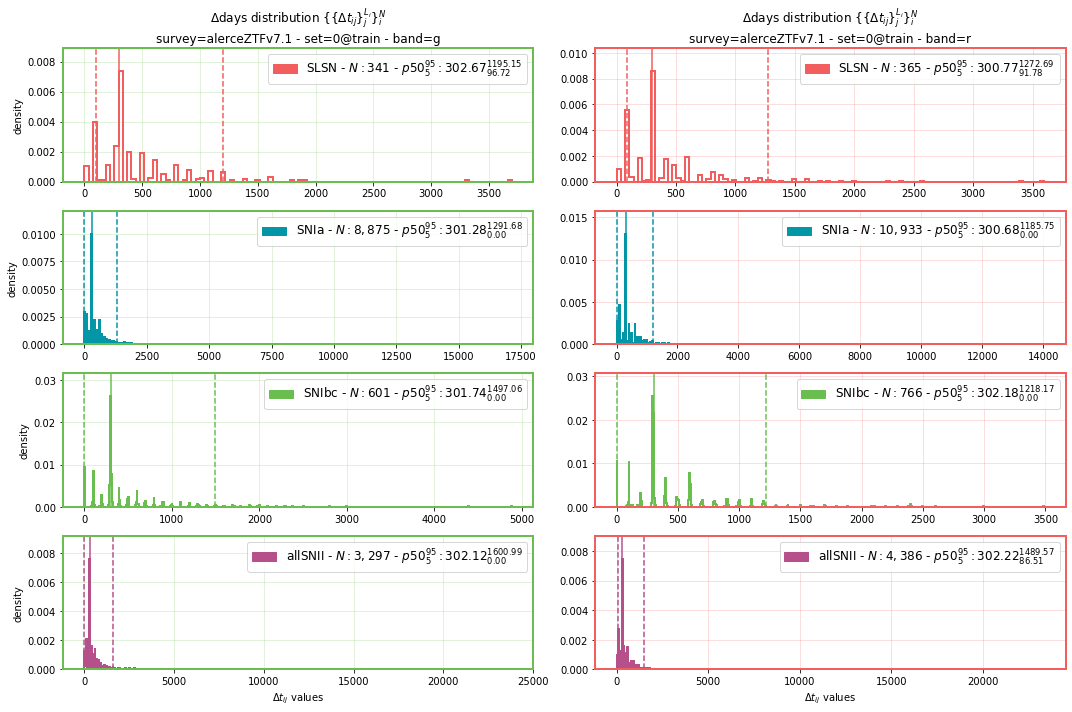

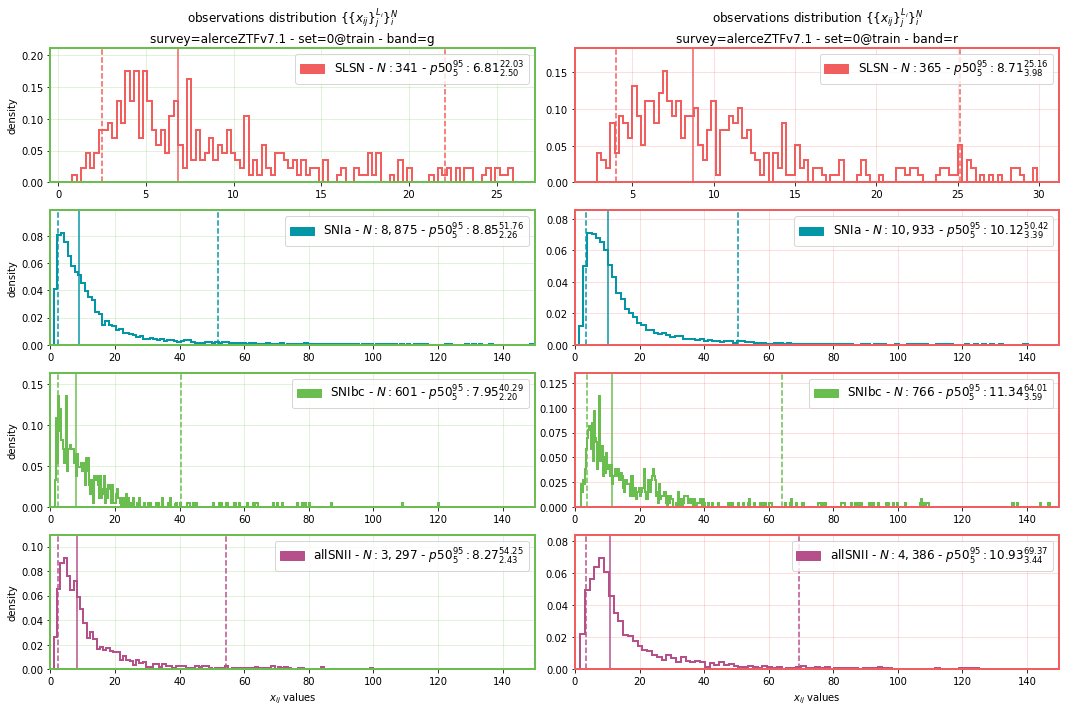

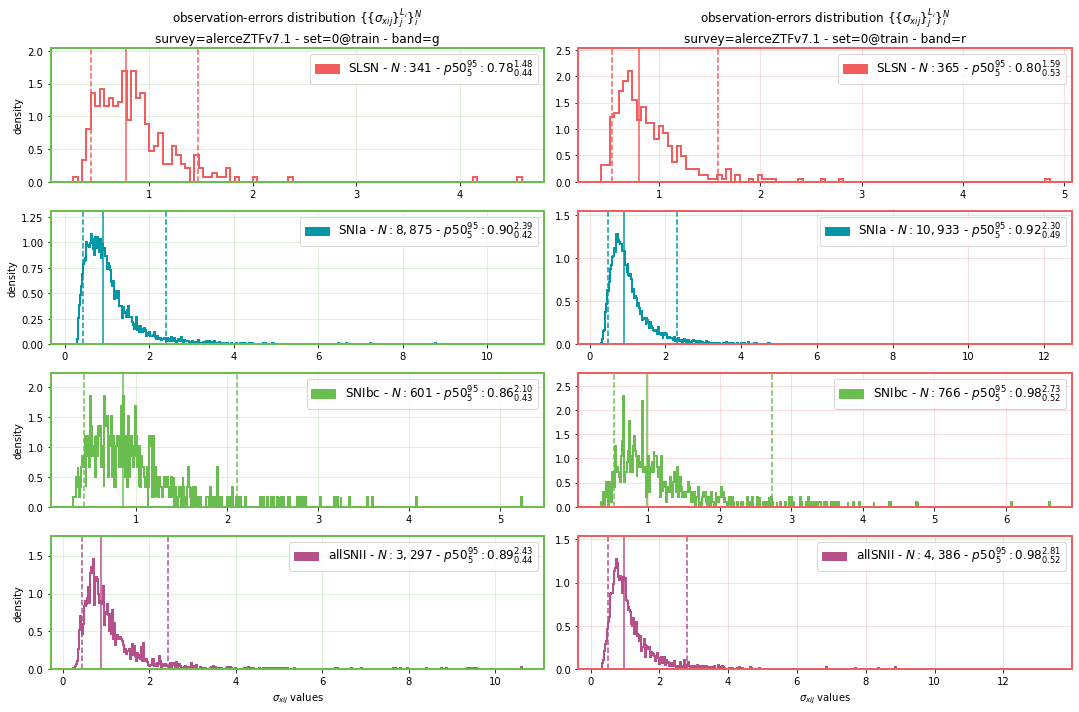

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from lchandler.plots.distrs import plot_values_distribution

kf = 0
set_name = f'{kf}@train'
lcdataset[set_name].set_diff_parallel('days')
plot_values_distribution(lcdataset, set_name, 'd_days')
plot_values_distribution(lcdataset, set_name, 'obs')
plot_values_distribution(lcdataset, set_name, 'obse')

In [5]:
%load_ext autoreload
%autoreload 2
from lcclassifier.datasets import CustomDataset

dataset_kwargs = {
    'max_day':150.,
    #'te_features':0,
    'te_features':4,
}
#attrs':['days','obs', 'obse']
in_attrs = ['obs', 'obse']
#'attrs':['d_days','obs', 'obse']
rec_attr = 'obs'
train_dataset = CustomDataset(lcdataset, f'{kf}@train.{method}', in_attrs, rec_attr, **dataset_kwargs)
val_dataset = CustomDataset(lcdataset, f'{kf}@val.{method}', in_attrs, rec_attr, **dataset_kwargs)
train_dataset.transfer_metadata_to(val_dataset) # transfer metadata to val/test
print('train_dataset:', train_dataset)
print('val_dataset:', val_dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
train_dataset: CustomDataset(lcset_len=37,248, max_day=150.00, max_len=207, te_periods=[300.0, 150.0], in_attrs=['obs', 'obse'], rec_attr=obs)
val_dataset: CustomDataset(lcset_len=12,384, max_day=150.00, max_len=183, te_periods=[300.0, 150.0], in_attrs=['obs', 'obse'], rec_attr=obs)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyError: 'te'

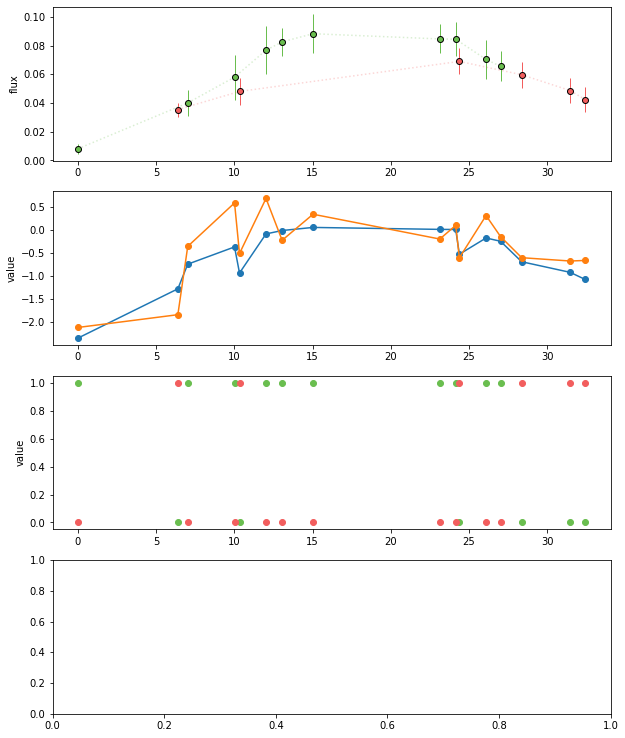

In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve
from lchandler import C_ as C_
import cProfile
%matplotlib inline

dataset = train_dataset
lcobj_name = dataset.get_random_stratified_lcobj_names()[0]

p = cProfile.Profile()
p.enable()
tdict, lcobj = dataset.get_item(lcobj_name, uses_len_clip=False, uses_daugm=False, return_lcobjs=True)
p.disable()
p.dump_stats('prof.prof')

model_input = tdict['input']
target = tdict['target']
len_lcobj = model_input['onehot'].sum()

figsize = (10,13)
fig, axs = plt.subplots(4, 1, figsize=figsize)

ax = axs[0]
for kb,b in enumerate(lcobj.bands):
    plot_lightcurve(ax, lcobj, b, label=f'{b} observation', max_day=dataset.max_day)
ax.set_ylabel('flux')
for kb,b in enumerate(lcobj.bands):
    #tmax = target[f'tmax.{b}']
    #label = f'{b} pm tmax - {tmax:.1f}[days]'
    #axs[0].axvline(tmax, ls='-', c=C_.COLOR_DICT[b], label=label)
    pass

ax = axs[1]
days = model_input['time'][...,0]
for ka,in_attr in enumerate(dataset.in_attrs):
    ax.plot(days[:len_lcobj], model_input['x'][:len_lcobj,ka], '-o', label=f'{C_.SHORT_NAME_DICT[in_attr]} (norm)')
ax.set_ylabel('value')

ax = axs[2]
for kb,b in enumerate(lcobj.bands):
    ax.plot(days[:len_lcobj], model_input['onehot'][:len_lcobj,kb], 'o', c=C_.COLOR_DICT[b], label=f'{b} onehot')
ax.set_ylabel('value')

ax = axs[3]
for kt in range(dataset.get_te_features_dims()):
    #label = '$TE^{('+str(kt)+')}$'+f' - {dataset.te_periods[kt//2]:.1f}[days]'
    te_text = 'sin' if kt%2==0 else 'cos'
    label = '$f_{TE}(t)|^{'+f'{dataset.te_periods[kt//2]:.1f}'+'d}_{'+te_text+'}$'
    ax.plot(days[:len_lcobj], model_input['te'][:len_lcobj,kt], '-o', label=label)
    if kt>4:
        break
ax.set_ylabel('value')

class_name = dataset.class_names[target['y']]
title = f'training light curve sample & model inputs & onehot & temporal encoding \n'
title += f'survey: {dataset.lcset.survey} - set: {dataset.lcset_name}'
title += f' - obs: {len_lcobj} - class: {class_name} - max_day: {dataset.max_day:.2f} - max_len: {dataset.max_len}'
#title += f' - training: {dataset.training}'
for ax in axs:
    #ax.legend(prop={'size':14})
    ax.legend(loc='upper right')
    ax.grid(alpha=0.5)
axs[0].set_title(title)
axs[-1].set_xlabel('days')
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
from lcclassifier.dataloaders import CustomDataLoader
from fuzzytorch.utils import print_tdict

loader_kwargs = {
    'batch_size':1,
    'num_workers':1,
}
random_subcrops = 3
s_train_loader = CustomDataLoader(train_dataset, shuffle=False, random_subcrops=random_subcrops, **loader_kwargs)
s_train_loader.eval()
dataset.set_max_day(40)

for k,tdict in enumerate(s_train_loader):
    model_input = tdict['input']
    target = tdict['target']
    print_tdict(tdict)
    print(model_input['time'][0,:,0])
    break

In [ ]:
%load_ext autoreload
%autoreload 2
from lcclassifier.dataloaders import CustomDataLoader
from fuzzytorch.utils import print_tdict

loader_kwargs = {
    'batch_size':1,
    #'num_workers':1, # bug?
}
random_subcrops = 3
s_train_loader = CustomDataLoader(train_dataset, shuffle=True, random_subcrops=random_subcrops, **loader_kwargs)
s_train_loader.train()

for k,tdict in enumerate(s_train_loader):
    model_input = tdict['input']
    target = tdict['target']
    print_tdict(tdict)
    for idx in range(len(model_input['x'])):
        print(model_input['x'][idx,:,0])
        print(model_input['onehot'][idx].sum(-1))
    assert 0